# 1 Загрузка библиотек

In [466]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce

# Модуль для работы с координатами
from geopy.geocoders import Nominatim
from functools import partial

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [467]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [468]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 2 Определение функций

In [469]:
# Определем функции
# функция для принятия решения о нормальности данных
def decision_normality(p):
    """Функция определяет нормальность распределения значений

    Args:
        p (p-value): значение-результат статистического теста, с помощью которого определяется нормальность рапсределения значений
    """
    
    print(f"p-value = {p:.3f}")
    if p <= alpha:
        print(f"р-значение меньше, чем заданный уровень значимости {alpha:.2}. Распределение отлично от нормального.")
    else:
        print(f"р-значение больше, чем заданный уровень значимости {alpha:.2}. Распределение является нормальным.")

# функция для принятия решения об отклонении нулевй гипотизы
def decision_gipothesis(p):
    """Функция определяет верность гипотез

    Args:
        p (p-value): значение-результат статистического теста, с помощью которого определяется выбор гипотезы
    """
    
    print(f"p-value = {p:.3f}")
    if p <= alpha:
        print(f"р-значение меньше, чем заданный уровень значимости {alpha:.2}. Отвергаем нулевую гипотезу в пользу альтернативной.")
    else:
        print(f"р-значение больше, чем заданный уровень значимости {alpha:.2}. У нас нет оснований отвергнуть нулевую гипотезу.")

# задаем уровень значимости 5%
alpha = 0.05

# 3 Чтение данных

In [470]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

hotels = pd.read_csv('data/hotels.csv')

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

## 3.1 Ознакомление с дата-сетами

In [471]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [472]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [473]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [474]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [475]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [476]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [477]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# 4 Обработка данных

## 4.1 Объединение тренировочного и тестового дата-сетов

In [478]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\dmitr\AppData\Local\Temp/ipykernel_12568/3686891825.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [479]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В дата-фрейме обнаружены пропуски значений в признаках "lat" и "lng"
<br> Также в дата-фрейме содержаться 8 признаков типа "object" и 10 числовых признаков.

In [480]:
data.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0


## 4.2 Создадим два списка признаков типов "object" и "int"

In [481]:
obj = []
num = []
for i in data.columns:
    if data[i].dtypes  == 'object':
        obj.append(i)
    else:
        num.append(i)
print(f'Столбцы "object":\n {obj}')
print()
print(f'Столбцы "numeric":\n {num}')

Столбцы "object":
 ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']

Столбцы "numeric":
 ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sample', 'reviewer_score']


Исследуем структуру информации в признаках типа "object"

In [482]:
for i in obj:
    print(i)
    print(f'"{data[i][0]}"\n')

hotel_address
"Via Senigallia 6 20161 Milan Italy"

review_date
"7/21/2017"

hotel_name
"Hotel Da Vinci"

reviewer_nationality
" United Kingdom "

negative_review
" Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices "

positive_review
" Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again "

tags
"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

days_since_review
"13 days"



В признаках (reviewer_nationality, negative_review, positive_review, tags) присутсвуют пробелы перед и после значений, удалим эти пробелы
В признаке "tags" удалим пробелы после поиска дублей, т.к. после преобразоания данного признака значения становятся списком и функция поиска дубликатов выдает ошибку.

In [483]:
# удаление пробелов
data['reviewer_nationality'] = data['reviewer_nationality'].apply (lambda x: x.strip())
data['negative_review'] = data['negative_review'].apply (lambda x: x.strip())
data['positive_review'] = data['positive_review'].apply (lambda x: x.strip())
#data['tags'] = data['tags'].apply (lambda x: x.replace("[' ", "").replace(" ']", '').split(" ', ' "))

In [484]:
#Проверка на удаление пробелов
for i in obj:
    print(i)
    print(f'"{data[i][0]}"\n')

hotel_address
"Via Senigallia 6 20161 Milan Italy"

review_date
"7/21/2017"

hotel_name
"Hotel Da Vinci"

reviewer_nationality
"United Kingdom"

negative_review
"Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices"

positive_review
"Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again"

tags
"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

days_since_review
"13 days"



Пробелы удалены

## 4.3 Поиск дубликатов в дата-сете

In [485]:
dupl_col = list(data.columns)

mask = data.duplicated(subset=dupl_col)
data_dupl = data[mask]

print(f'Число найденных дубликатов: {data_dupl.shape[0]}')

Число найденных дубликатов: 336


По правилам соревнования удалять строки не можем. Дублирующие записи пометим "1"

In [486]:
data['duplicates'] = mask.apply(lambda x: 1 if x else 0)
print((data['duplicates'].value_counts())[1]) # проверка суммой количество дублирующих строк

336


## 4.4 Поиск пропусков в признаках

In [487]:
#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)

<AxesSubplot:>

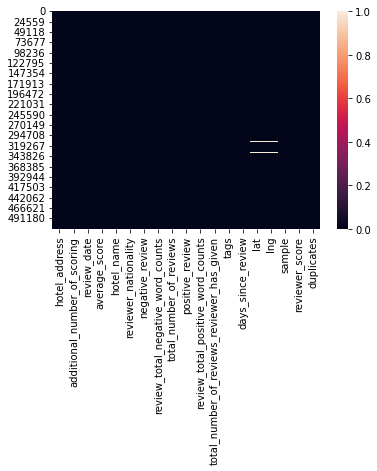

In [488]:
sns.heatmap(data.isnull()) # наглядная карта пропусков

In [489]:
is_null = data.isnull()
row_with_null = is_null.any(axis=1)
row_with_null = data[row_with_null]

In [490]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
duplicates                                       0
dtype: int64

Обнаружены пропуски в признаках "lat" и "lng"

In [491]:
#Удалим признаки с пропусками "lat" и "lng"
#data = data.drop(['lat', 'lng'], axis=1)
#sns.heatmap(data.isnull())

## 4.5 Преобразование даты "review_date"

In [492]:
# Преобразуем признак в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'])

In [493]:
# проверка 
#data['review_date'].info()

In [494]:
# из признака даты сформируем два отдельных признака год и месяц

# формирование признака "месяц"
data['review_month'] = data['review_date'].dt.month

# формируе признак "год"
data['review_year'] = data['review_date'].dt.year

# удаление признака "review_date"
data.drop('review_date', axis=1, inplace=True)

# проверка
data.info()
# признаки "месяц" и "год" созданы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

## 4.6 Преобразование адреса отеля "hotel_address"

In [495]:
# анализ структуры записи адреса отеля

print(data['hotel_address'][0])
print(data['hotel_address'][10])
# последнее слово - страна, предпоследнее слово - город

Via Senigallia 6 20161 Milan Italy
Via Giorgio Stephenson 55 20157 Milan Italy


In [496]:
# сформируем два новых признака "country" и "city"
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2])

# проверка
data[['country', 'city']]
# новые признаки сформированы
# некорректно обработалось наименование United Kongdom

,country,city
0,Italy,Milan
1,Netherlands,Amsterdam
2,Spain,Barcelona
3,Italy,Milan
4,Netherlands,Amsterdam
...,...,...
515733,Kingdom,United
515734,Austria,Vienna
515735,Kingdom,United
515736,Kingdom,United


In [497]:
# коррекция признаков "country" и "city"

data['country'] = data['country'].apply(lambda x: 'UK' if x == 'Kingdom' else x)
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)

# проверка
data[['country', 'city']]

,country,city
0,Italy,Milan
1,Netherlands,Amsterdam
2,Spain,Barcelona
3,Italy,Milan
4,Netherlands,Amsterdam
...,...,...
515733,UK,London
515734,Austria,Vienna
515735,UK,London
515736,UK,London


In [498]:
# удаление признака "hotel_address"
#data.drop('hotel_address', axis=1, inplace=True)

#data.info() 

## 4.7 Кодирование признаков "country" и "city"

In [499]:
# выясним количество уникальных значений стран и городов
display(f'Уникальное количество стран: {data["country"].nunique()}: {data["country"].unique()}')
display(f'Уникальное количество городов: {data["city"].nunique()}: {data["city"].unique()}')

"Уникальное количество стран: 6: ['Italy' 'Netherlands' 'Spain' 'UK' 'France' 'Austria']"

"Уникальное количество городов: 6: ['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']"

In [500]:
# закодируем наименование стран и городов методом однократного кодирования
# dummies метод не подходит, т.к. удаляет кодируемый признак 
#df = data.copy()
#df = pd.get_dummies(df, columns=['country'], drop_first=False)
#df = pd.get_dummies(df, columns=['city'], drop_first=False)

#OneHot кодирование не подходит т.к. создает признаки с неинформативным наименованием
#encoder = ce.OneHotEncoder(cols=['country'])
#type_bin = encoder.fit_transform(data['country'])
#data2 = pd.concat([data, type_bin], axis=1)

In [501]:
# кодируем посредством создания списка наименований будущих признаков и lambda-функции

# создаем список стран
country_list = list(data['country'].unique())

# циклом создаем новые признаки и присваиваем признакам наименование стран строчными буквами
for i in country_list:
    country_col = i.lower()
    # однократное кодирование через lambda-функцию
    data[country_col] = data['country'].apply(lambda x: 1 if i == x else 0)

In [502]:
# создаем список городов
city_list = list(data['city'].unique())

# циклом создаем новые признаки и присваиваем признакам наименование городов строчными буквами
for i in city_list:
    city_col = i.lower()
    # однократное кодирование через lambda-функцию
    data[city_col] = data['city'].apply(lambda x: 1 if i == x else 0)

## 4.8 Добавление дополнительных признаков населения стран и городов

In [503]:
# Добавим три признака:
# население страны,
# население города,
# соотношение населения города к населению страны

# словарь население стран
country_popul = {
    'UK': 665111098,
    'Netherlands': 17032845,
    'France': 64938716,
    'Spain': 46070146,
    'Italy': 59797978,
    'Austria': 8592400
}

data['country_popul'] = data['country'].map(country_popul)


# словарь население городов
сity_popul = {
    'Paris': 2187526,
    'London': 8825000,
    'Milan': 1378000,
    'Vienna': 1888776,
    'Barcelona': 1628936,
    'Amsterdam': 1123000
}

data['сity_popul'] = data['city'].map(сity_popul)

# соотношение населения города к населению страны
data['diff_popul'] = round(data['сity_popul'] / data['country_popul'], 4) # округлим до 4 знаков

In [504]:
data.head(1)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,austria,milan,amsterdam,barcelona,london,paris,vienna,country_popul,сity_popul,diff_popul
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,...,0,1,0,0,0,0,0,59797978,1378000,0.023


## 4.9 Восстановление пропущенных признаков координат городов

In [505]:

# создадим дата-сет с пропущенными координатами
city_geo = data[(data['lat'].isna()) & (data['lng'].isna())]['city']
#print(city_geo.unique())

#создадим список городов с пропущенными координатами
city_geo_str = list(city_geo.unique())
city_geo_str

['Vienna', 'Paris', 'Barcelona']

In [506]:
# восстановление пропущенных координат "lat" и "lng"
geolocator = Nominatim(user_agent='USER_AGENT')

for i in city_geo_str:
    geocode = partial(geolocator.geocode, language="en")
    location = geolocator.geocode(i)
    print(str(geocode(i)).split(',')[0])
    
    # округлим значение координат до 8 символов
    if len(str(location.latitude)) > 8 or len(str(location.longitude)) > 8:
        lat = float(str(location.latitude)[:8])
        lng = float(str(location.longitude)[:8])
    else:
        lat = location.latitude
        lng = location.longitude
    
    # заполнение отсутствующих координат по соответсвующим городам
    data['lat'] = np.where(((data['lat'].isna()) & (data['city'] == i)), lat, data['lat']).astype('float64')
    data['lng'] = np.where(((data['lng'].isna()) & (data['city'] == i)), lng, data['lng']).astype('float64')
    #print(lat, lng)

Vienna
Paris
Barcelona


In [507]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

<AxesSubplot:>

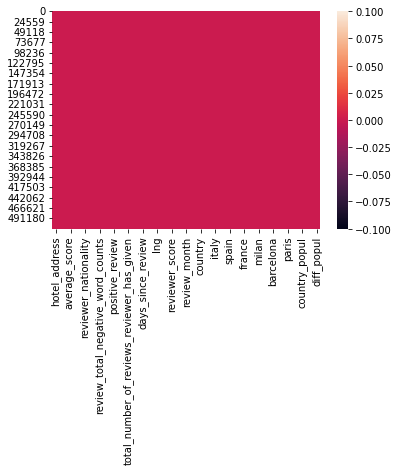

In [508]:
# проверка дата-сета на наличие пропусков
sns.heatmap(data.isnull())

# пропусков не обнаружено

## 4.10 Анализ национальности (гражданства) посетителей отелей

In [509]:
# Произведем подсчет уникальных значений национальностей посетителей
print(f'Количество уникальных значений национальностей посетителей отелей: {data["reviewer_nationality"].nunique()}')

Количество уникальных значений национальностей посетителей отелей: 227


In [510]:
# отбирем 15 самых часто встречаемых значений национальности, остальным присвоим значение other и закодируем
data['reviewer_nationality'].value_counts().head(20)

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
France                        7296
Israel                        6610
Italy                         6114
Belgium                       6031
Turkey                        5444
Kuwait                        4920
Spain                         4737
Romania                       4552
Russia                        3900
South Africa                  3821
Name: reviewer_nationality, dtype: int64

In [511]:
# изменим значение национальность - United Kingdom на UK, чтобы в дальшейшем корректно отобразить внутрених туристов UK == UK
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'UK' if x == 'United Kingdom' else x)

In [512]:
# создадим дата-сет с 15 часто встречаемых значений
national_15 = data['reviewer_nationality'].value_counts().nlargest(15).index

# заменим другие национальности значением other
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in national_15 else 'Other')

In [513]:
# чтобы не создавать 15 новых колонок применим бинарное кодирование к признаку "reviewer_nationality"
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [514]:
# создадим признак для посетителей отелей внутри своей страны
data['local_reviewer'] = data['reviewer_nationality'] == data['country']
 
data['local_reviewer'].value_counts()

False    340045
True     175693
Name: local_reviewer, dtype: int64

# Разрез

In [ ]:
data.nunique(dropna=False)

In [ ]:
data['review_year'].unique()

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [ ]:
#Уменьшаем объем памяти выделенную под дата-сет, где возможно int64 преобразуем в int8
data2 = data.copy()
data2 = data2.astype({'italy':np.int8, 'netherlands':np.int8, 'spain':np.int8, 'uk':np.int8, 'france':np.int8, 'austria':np.int8})
data2 = data2.astype({'milan':np.int8, 'amsterdam':np.int8, 'barcelona':np.int8, 'london':np.int8, 'paris':np.int8, 'vienna':np.int8})
data2 = data2.astype({'reviewer_nationality_0':np.int8, 'reviewer_nationality_1':np.int8, 'reviewer_nationality_2':np.int8, 'reviewer_nationality_3':np.int8, 'reviewer_nationality_4':np.int8})


In [ ]:
data.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission2.csv', index=False)
sample_submission.head(10)